Regression (Linear, XGBoost)

SHAP for feature importance

KPI dashboard

Time series forecasting (Prophet)

Scenario simulation

Clustering for segmentation

Anomaly detection

Executive summary output

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import shap
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load dataset
df = pd.read_csv(r"D:\JOB\5 Performance analyst\1 Business performance analyst\kpi_dashboard_dataset.csv")

In [6]:
df

,date,department,region,employees,operational_cost,marketing_spend,customer_satisfaction,new_customers,customer_retention_rate,sales_volume,revenue
0,2023-05-01,Sales,South,53,44013.43,27432.89,4.82,49,0.71,235165.77,216621.67
1,2022-03-01,Sales,North,35,61954.25,24464.65,4.59,38,0.63,229357.77,225457.95
2,2021-08-01,Marketing,Central,48,61730.04,24256.18,3.50,46,0.85,218889.20,212593.12
3,2022-09-01,Finance,West,63,68282.31,27136.96,4.27,52,0.70,306557.79,281959.51
4,2022-07-01,Marketing,South,27,19786.26,33621.22,4.33,44,0.85,242456.19,267293.14
...,...,...,...,...,...,...,...,...,...,...,...
9995,2023-07-01,Operations,South,76,35653.22,12618.66,3.44,50,0.75,253195.01,261263.33
9996,2023-07-01,Finance,Central,9,38021.10,22078.19,4.48,41,0.90,275796.69,256095.92
9997,2022-01-01,Marketing,East,96,59547.84,38131.11,4.70,45,0.73,209175.42,192049.72
9998,2022-02-01,Marketing,North,70,56540.73,45021.90,3.19,69,0.63,239596.35,228024.88


# Preprocessing

In [7]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')  # Create month column

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['department', 'region'], drop_first=True)


In [8]:
# Define features and target
X = df_encoded.drop(columns=['revenue', 'date', 'month'])
y = df_encoded['revenue']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Train XGBoost model
xgb = XGBRegressor(random_state=42, n_estimators=100)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [10]:
# Print evaluation scores
print("Linear R2:", r2_score(y_test, y_pred_lr))
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))

Linear R2: 0.945476251443567
XGBoost R2: 0.9366485679191453


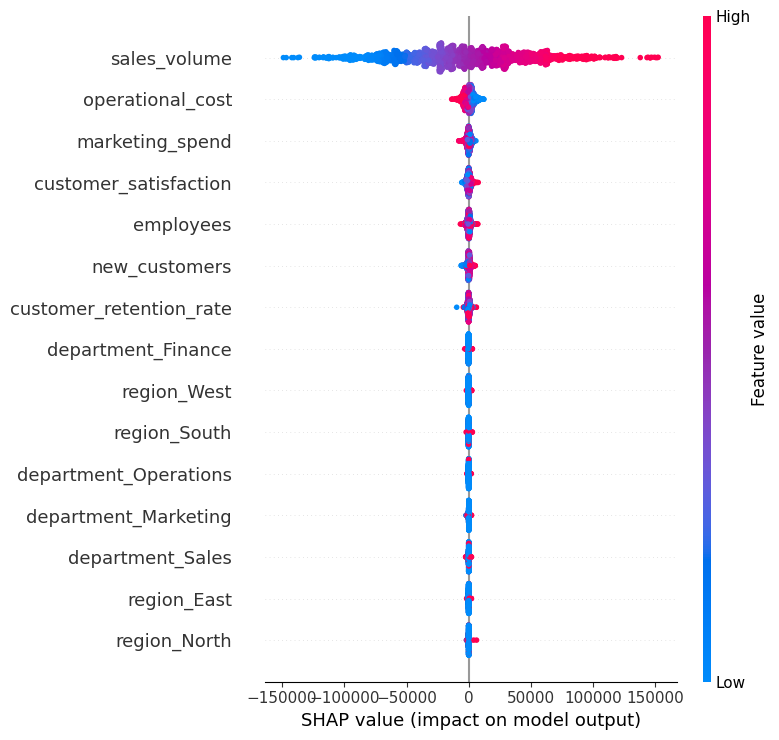

In [11]:
# SHAP value explanation
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)  # SHAP summary plot

In [12]:
# KPI aggregation by department and region
agg_kpis = df.groupby(['department', 'region']).agg({
    'revenue': 'mean',
    'sales_volume': 'mean',
    'new_customers': 'mean',
    'customer_satisfaction': 'mean',
    'operational_cost': 'mean',
    'marketing_spend': 'mean'
}).reset_index().round(2)
print(agg_kpis.sort_values(by='revenue'))  # Display aggregated KPIs


          department   region    revenue  sales_volume  new_customers  \
0   Customer Support  Central  192385.26     197771.94          49.88   
22             Sales    North  192601.37     196308.72          50.14   
6            Finance     East  193806.22     197528.71          50.59   
21             Sales     East  194018.14     199493.66          49.82   
11         Marketing     East  194020.76     197124.53          50.27   
24             Sales     West  194072.49     197211.78          50.21   
8            Finance    South  194302.68     198171.11          50.06   
13         Marketing    South  194553.66     198220.44          50.31   
10         Marketing  Central  195063.21     200389.35          50.39   
2   Customer Support    North  195599.72     199856.71          49.88   
16        Operations     East  195615.12     199547.73          49.35   
17        Operations    North  195751.92     200282.33          49.92   
5            Finance  Central  195765.51     199591

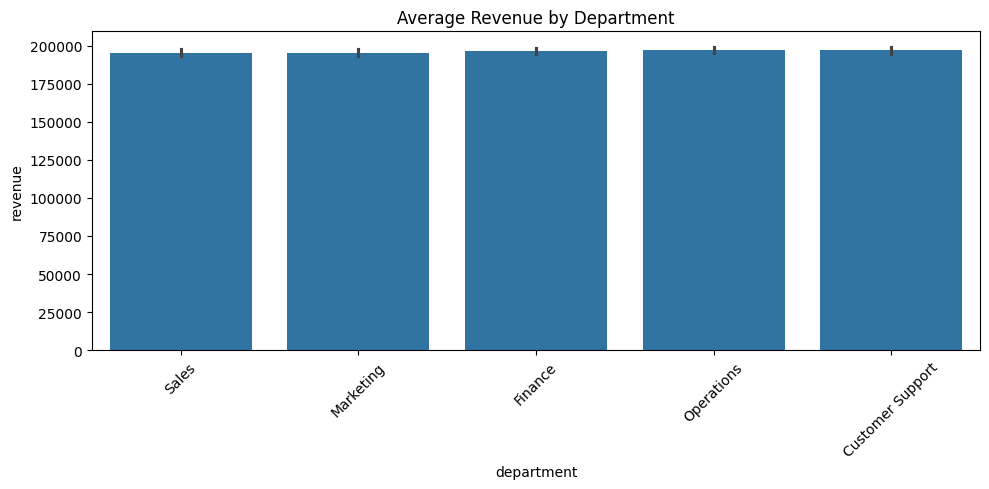

In [13]:
# Department-wise revenue visualization
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='department', y='revenue', estimator=np.mean)
plt.title("Average Revenue by Department")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Importing plotly failed. Interactive plots will not work.
16:21:42 - cmdstanpy - INFO - Chain [1] start processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing


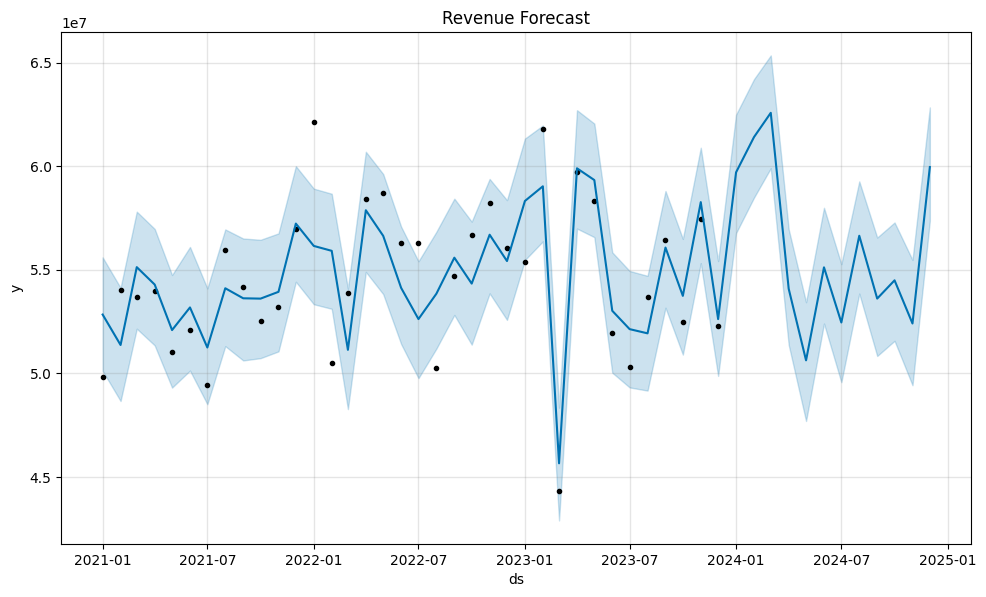

In [14]:
# Time series trend analysis for forecasting (using Prophet)
from prophet import Prophet

df_prophet = df[['date', 'revenue']].copy()
df_prophet = df_prophet.groupby('date').sum().reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires these column names

model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=12, freq='MS')  # Forecast 12 months ahead
forecast = model.predict(future)
model.plot(forecast)  # Plot the forecast
plt.title("Revenue Forecast")
plt.show()

In [15]:
# Scenario simulation: What if customer satisfaction increases by 10%
X_sim = X_test.copy()
if 'customer_satisfaction' in df.columns:
    X_sim['customer_satisfaction'] = X_sim['customer_satisfaction'] * 1.1  # Increase by 10%
    y_sim = xgb.predict(X_sim)
    print("Revenue Impact if Satisfaction +10%:", np.mean(y_sim - y_pred_xgb))


Revenue Impact if Satisfaction +10%: 528.1467


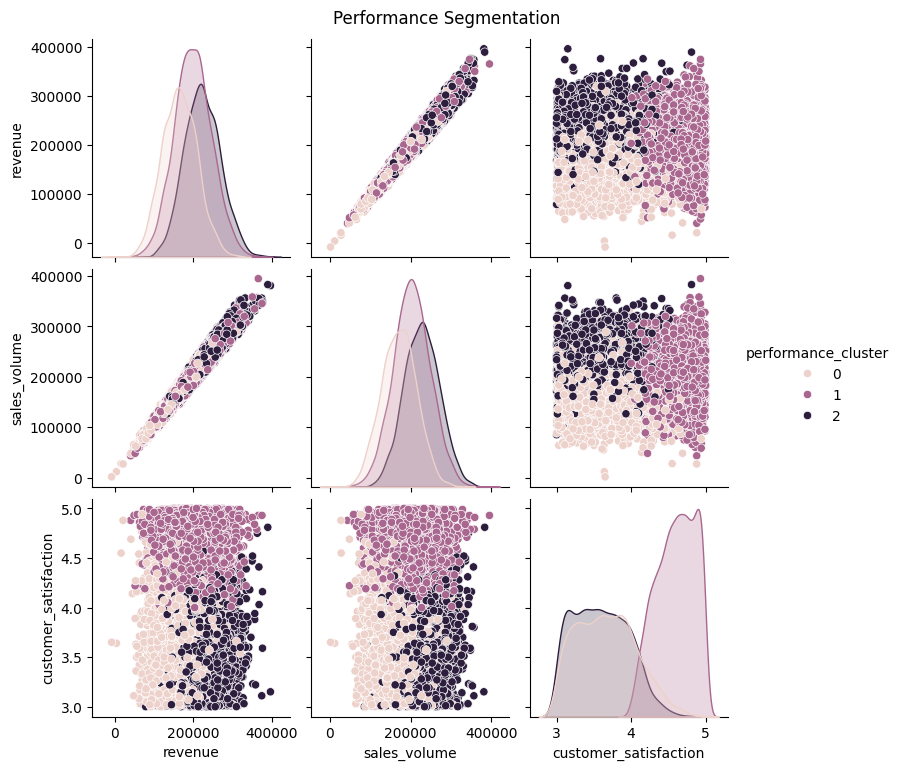

In [16]:
# Clustering for identifying department performance segments
scaler = StandardScaler()
cluster_data = df[['sales_volume', 'new_customers', 'customer_satisfaction', 'operational_cost', 'marketing_spend']]
cluster_scaled = scaler.fit_transform(cluster_data)

kmeans = KMeans(n_clusters=3, random_state=42)
df['performance_cluster'] = kmeans.fit_predict(cluster_scaled)  # Add cluster labels

sns.pairplot(df, hue='performance_cluster', vars=['revenue', 'sales_volume', 'customer_satisfaction'])
plt.suptitle("Performance Segmentation", y=1.02)
plt.show()

In [17]:
# Anomaly detection using Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df_encoded.drop(columns=['revenue', 'date', 'month']))
print("Anomalies Detected:", df['anomaly'].value_counts())

Anomalies Detected:  1    9900
-1     100
Name: anomaly, dtype: int64


In [18]:
# Summary report generation (as text output)
top_departments = agg_kpis.sort_values(by='revenue', ascending=False).head(3)
low_departments = agg_kpis.sort_values(by='revenue').head(3)

print("\n--- Executive Summary ---")
print("Top Performing Departments:")
print(top_departments[['department', 'region', 'revenue']])

print("\nUnderperforming Areas:")
print(low_departments[['department', 'region', 'revenue']])

print("\nKey Drivers of Revenue (from SHAP): See SHAP Summary Plot Above")



--- Executive Summary ---
Top Performing Departments:
         department region    revenue
3  Customer Support  South  199983.70
4  Customer Support   West  199918.55
7           Finance  North  199583.14

Underperforming Areas:
          department   region    revenue
0   Customer Support  Central  192385.26
22             Sales    North  192601.37
6            Finance     East  193806.22

Key Drivers of Revenue (from SHAP): See SHAP Summary Plot Above
